# ALPHA
Created: 08/08/24 \
Updated: 08/14/2024 

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08152024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
#### set theme for all plots
# %matplotlib inline
# from matplotlib import rc
# rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("talk")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load Regression DF

In [9]:
band = 'alpha'

In [10]:
band_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
band_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [11]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [12]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [13]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
count_thresh = 50

keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=count_thresh].tolist()

keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg']

In [14]:
####### NEW DATA FRAME 
reg_df = band_df.copy()
reg_df = reg_df[reg_df.roi.isin(keep_rois)]
len(reg_df)

222615

In [15]:
np.max(reg_df.band_pow)

4.791999971900266

In [16]:
np.min(reg_df.band_pow)

-0.9750844772396912

# POW ~ Outcome Vars Regressions

In [17]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

In [18]:
final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          band_pow   
No. Observations:           222592           Method:                      ML         
No. Groups:                 1620             Scale:                       0.1028     
Min. group size:            65               Log-Likelihood:              -66230.5220
Max. group size:            148              Converged:                   Yes        
Mean group size:            137.4                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.060    0.003 -22.964 0.000 -0.065 -0.055
C(GambleChoice)[T.safe]                   -0.008    0.002  -3.718 0.000 -0.012

132645.74049620726


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [19]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
final_vars   = ['C(GambleChoice)','TotalProfit','decisionCPE']

In [20]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        final_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [21]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

In [22]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=-4.520549209617716, pvalue=1.0772706065053342e-05, df=192),
 'dmpfc': TtestResult(statistic=0.7849632104609308, pvalue=0.4333392284711133, df=215),
 'amy': TtestResult(statistic=0.7019998478978609, pvalue=0.4841355564859121, df=112),
 'sts': TtestResult(statistic=-0.1572468102826188, pvalue=0.8752563146590312, df=154),
 'ains': TtestResult(statistic=0.013300187050136539, pvalue=0.9894261334623586, df=70),
 'vlpfc': TtestResult(statistic=3.430152285081698, pvalue=0.0009517128895245981, df=81),
 'hpc': TtestResult(statistic=-6.428270697877722, pvalue=2.0915353253281005e-09, df=134),
 'mtg': TtestResult(statistic=-3.027672510056167, pvalue=0.0037213514417608713, df=56),
 'ofc': TtestResult(statistic=-11.821445614469702, pvalue=7.9828863258777265e-25, df=201),
 'pins': TtestResult(statistic=4.203338675171669, pvalue=9.039792728471659e-05, df=59),
 'dlpfc': TtestResult(statistic=3.328761694910109, pvalue=0.0012003815217849674, df=106),
 'smg': TtestResult(stati

In [23]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_GambleChoice,raw_TotalProfit,raw_decisionCPE,Intercept,GambleChoice,TotalProfit,decisionCPE,band
0,DA023_lac1-lac2,DA023,acc,14,0.005368,-0.021049,-0.007116,0.001640,-0.003814,-0.024877,-0.002615,0.000155,alpha
1,DA023_lac2-lac3,DA023,acc,14,0.032744,-0.056742,0.024822,0.004611,0.023562,-0.060571,0.029323,0.003125,alpha
2,DA023_lac3-lac4,DA023,acc,14,0.003574,0.003496,0.012260,-0.000227,-0.005608,-0.000333,0.016762,-0.001713,alpha
3,MS002_lacas1-lacas2,MS002,acc,14,0.014061,-0.015847,0.018987,0.001345,0.004879,-0.019676,0.023489,-0.000141,alpha
4,MS002_lacas2-lacas3,MS002,acc,14,-0.032475,0.055692,-0.029203,-0.004661,-0.041657,0.051864,-0.024702,-0.006147,alpha
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.041692,-0.017419,-0.017599,-0.002431,0.001617,-0.011574,-0.000085,-0.009782,alpha
1616,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.063197,-0.028554,-0.033501,-0.006170,0.023121,-0.022709,-0.015987,-0.013521,alpha
1617,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.023607,0.041649,0.008631,-0.000510,-0.016469,0.047494,0.026145,-0.007861,alpha
1618,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.054161,-0.023449,0.004067,0.007857,0.014086,-0.017605,0.021581,0.000505,alpha


In [24]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [25]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [26]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [27]:
fe_results['roi_cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]

In [28]:
fe_results

,Intercept,C(GambleChoice)[T.safe],TotalProfit,decisionCPE,roi,roi_cpe_pval
0,-0.009182,-0.003828,0.004502,-0.001486,acc,0.6287
1,-0.044555,-0.011485,-0.003482,0.001259,dmpfc,0.7737
2,-0.066896,0.001591,0.033065,0.001365,amy,0.8046
3,-0.077736,-0.045926,0.036936,-0.000301,sts,0.9586
4,-0.031695,0.002379,-0.022084,0.000029,ains,0.9967
5,-0.046634,-0.022421,0.009182,0.005634,vlpfc,0.4280
6,-0.137608,0.015738,-0.001350,-0.008325,hpc,0.0954
7,-0.111241,-0.044709,0.030352,-0.021523,mtg,0.0881
8,-0.061360,-0.010619,0.003153,-0.004826,ofc,0.1864
9,-0.070350,0.024179,0.016352,0.005789,pins,0.3937


In [29]:
# bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha = 0.01

bonferr_alpha

0.01

In [30]:
sig_rois = fe_results.roi[fe_results.roi_cpe_pval <= bonferr_alpha].tolist()
sig_rois

[]

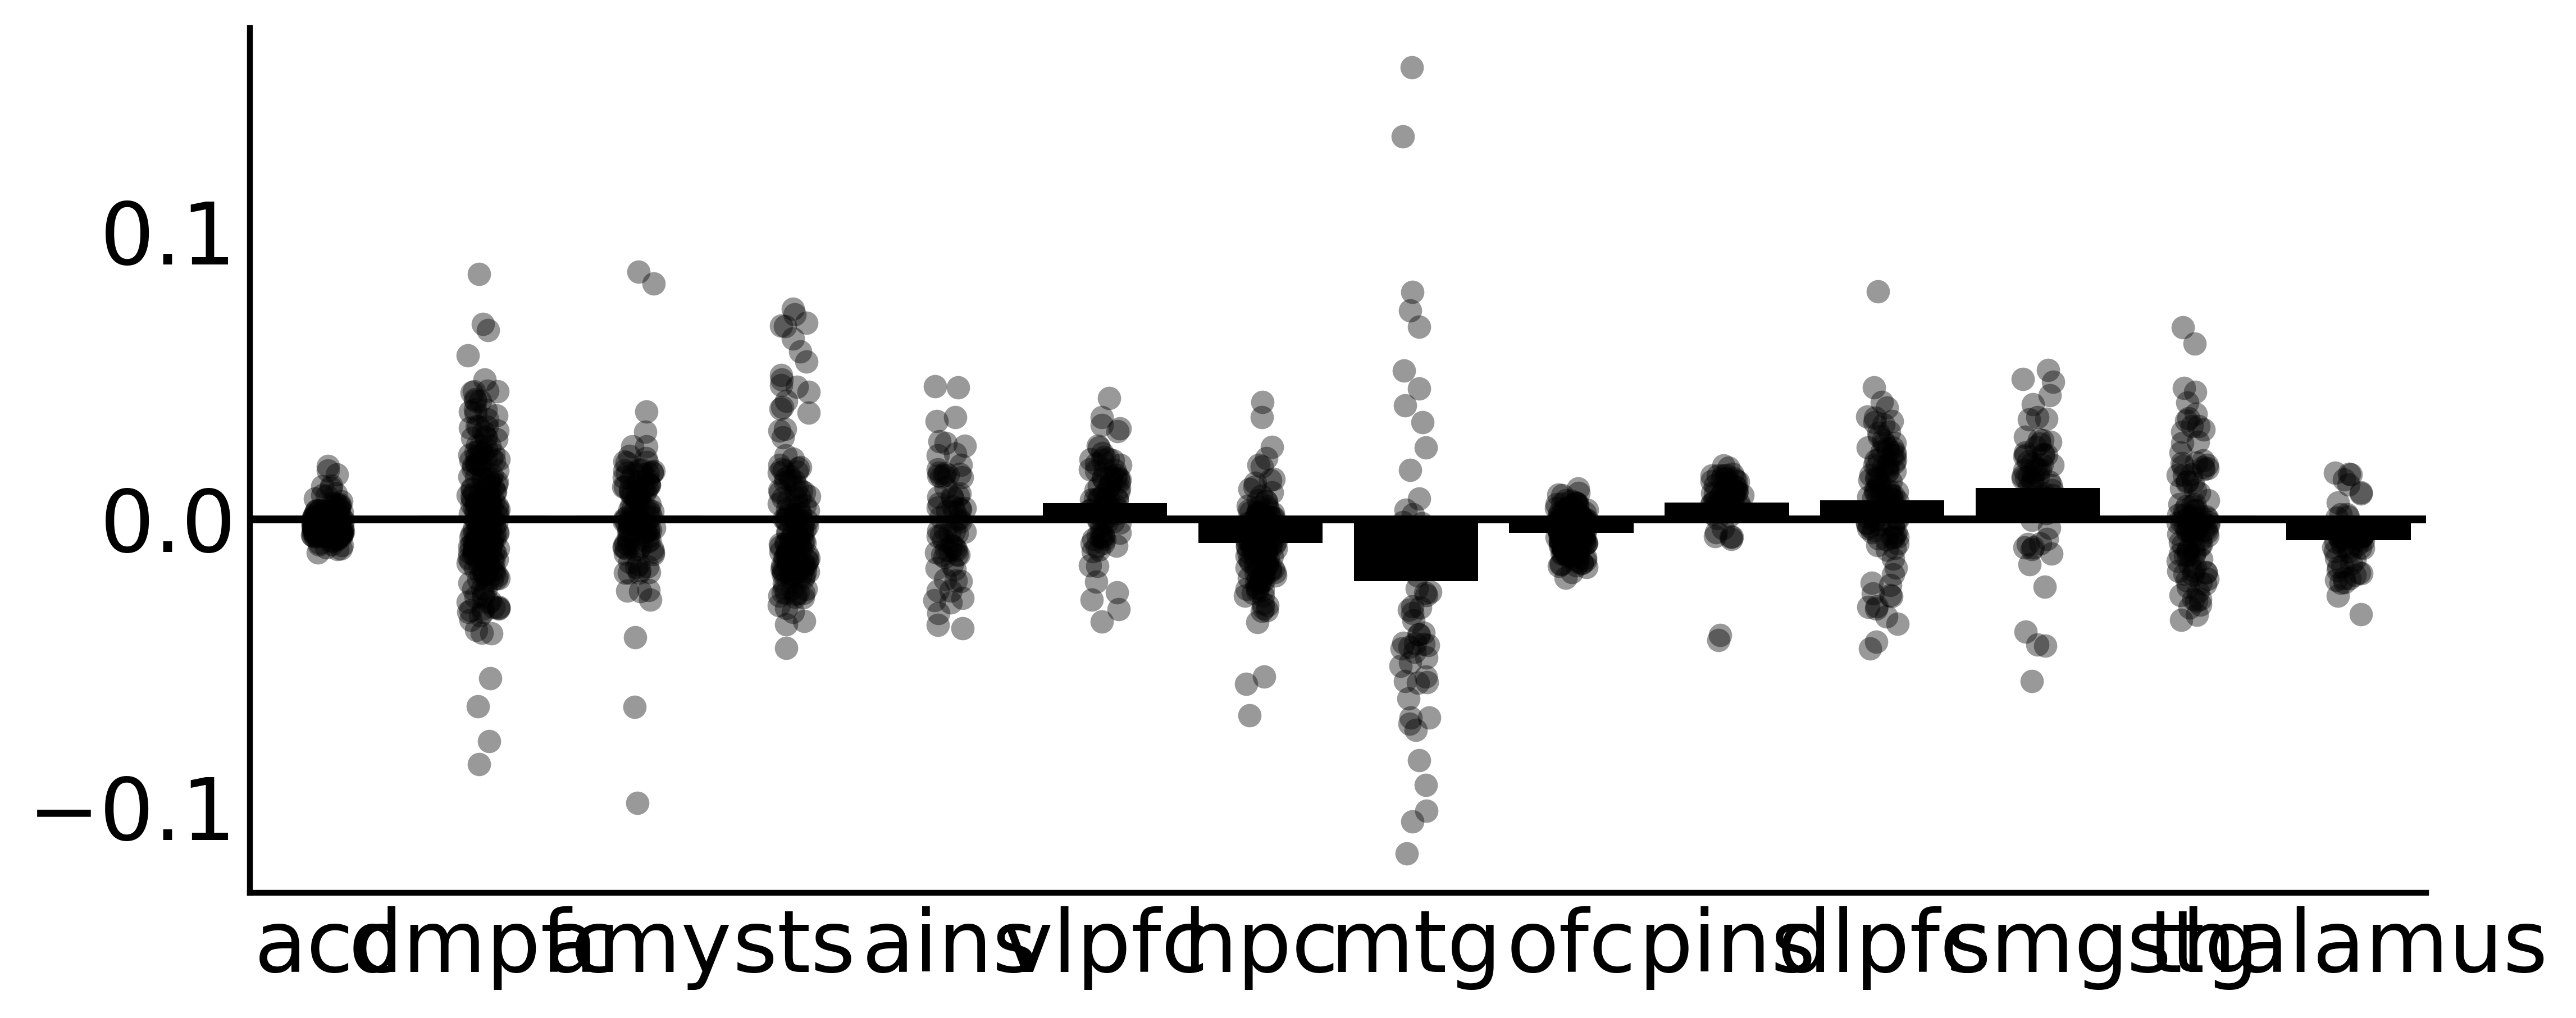

In [32]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE')


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


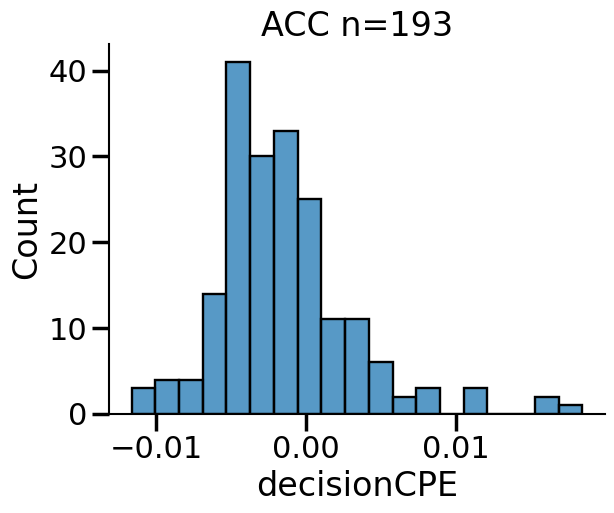

In [33]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
plt.title(f'ACC n={n}')

sns.despine()

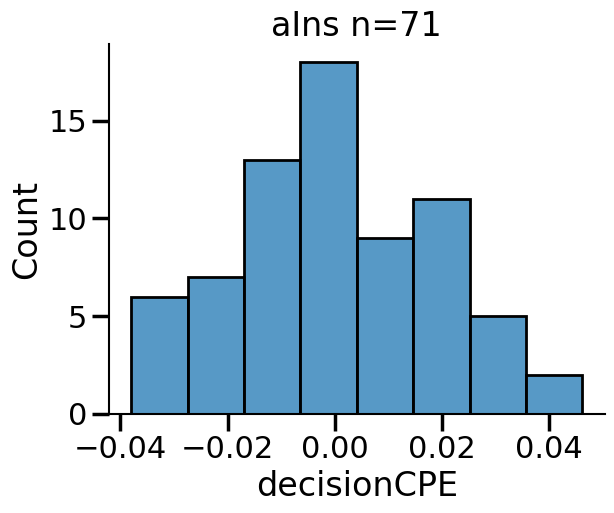

In [34]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ains'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ains'].decisionCPE)
plt.title(f'aIns n={n}')

sns.despine()

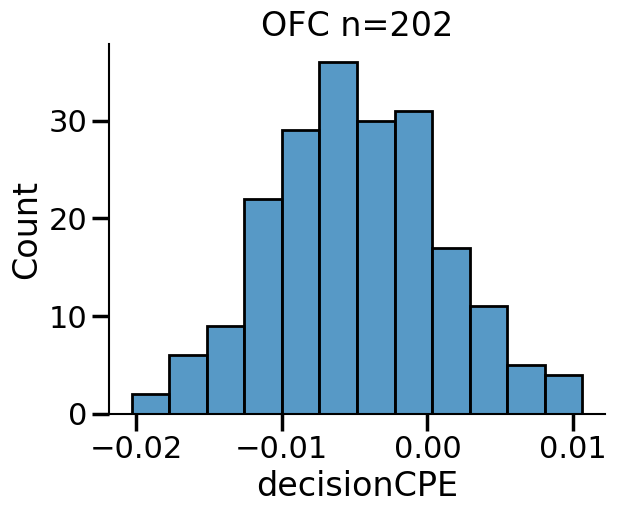

In [35]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
plt.title(f'OFC n={n}')

sns.despine()

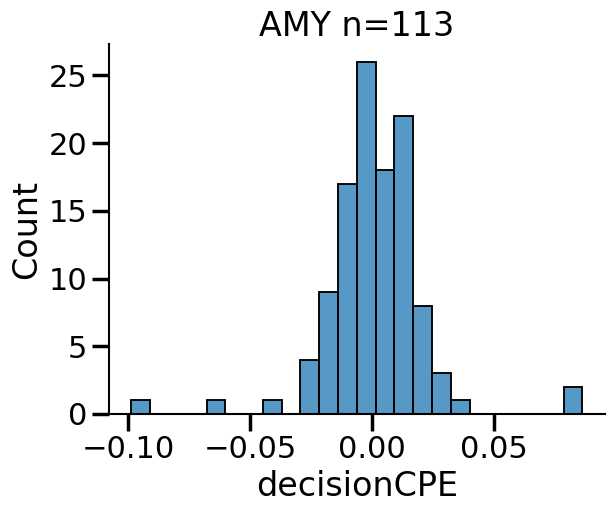

In [36]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'amy'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'amy'].decisionCPE)
plt.title(f'AMY n={n}')

sns.despine()

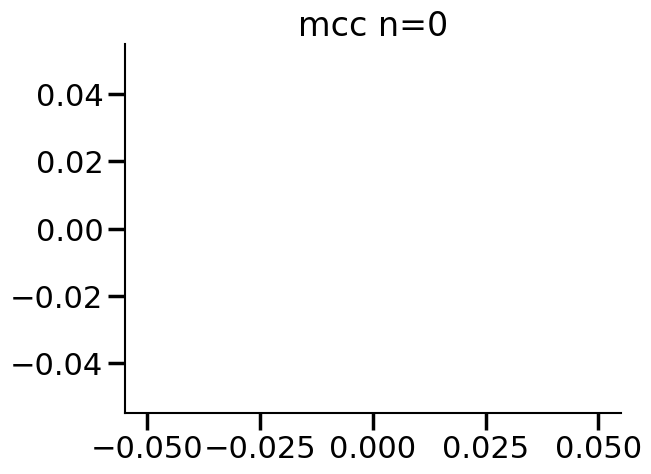

In [37]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'mcc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'mcc'].decisionCPE)
plt.title(f'mcc n={n}')

sns.despine()

In [38]:
sig_rois

[]

In [39]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.06864341938115211 0.34284981976441736
dmpfc pearsonr 0.201350512825144 0.0029531817472051125
amy pearsonr -0.4431922274763558 8.837299388324654e-07
sts pearsonr 0.02424629281941572 0.7645856718873218
ains pearsonr -0.06552928624293015 0.5871691360535657
vlpfc pearsonr -0.09993197182945043 0.3717131421756745
hpc pearsonr -0.3943681068513729 2.2144802702061207e-06
mtg pearsonr -0.2861583324721034 0.030933085034755153
ofc pearsonr -0.22302677434420853 0.0014206785207424163
pins pearsonr 0.16029969552014806 0.2211460127446673
dlpfc pearsonr 0.2013776396537699 0.03752932523612955
smg pearsonr -0.0763820295156589 0.5421494587381694
stg pearsonr 0.16707304470640183 0.08847617082990454
thalamus pearsonr -0.0974694167137637 0.466685994879241


In [40]:
sig_rho

[('dmpfc', 0.201350512825144, 0.0029531817472051125),
 ('amy', -0.4431922274763558, 8.837299388324654e-07),
 ('hpc', -0.3943681068513729, 2.2144802702061207e-06),
 ('mtg', -0.2861583324721034, 0.030933085034755153),
 ('ofc', -0.22302677434420853, 0.0014206785207424163),
 ('dlpfc', 0.2013776396537699, 0.03752932523612955)]

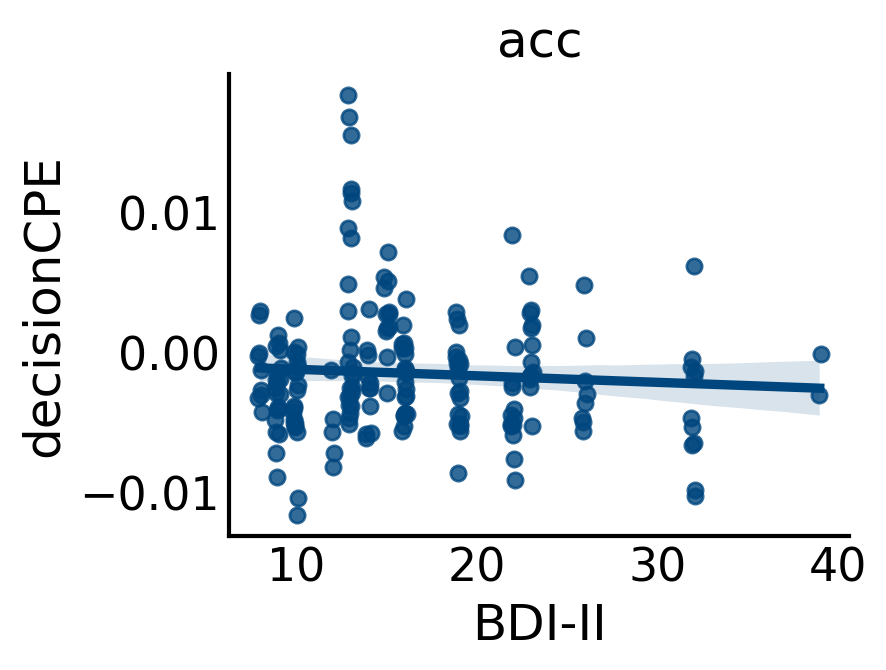

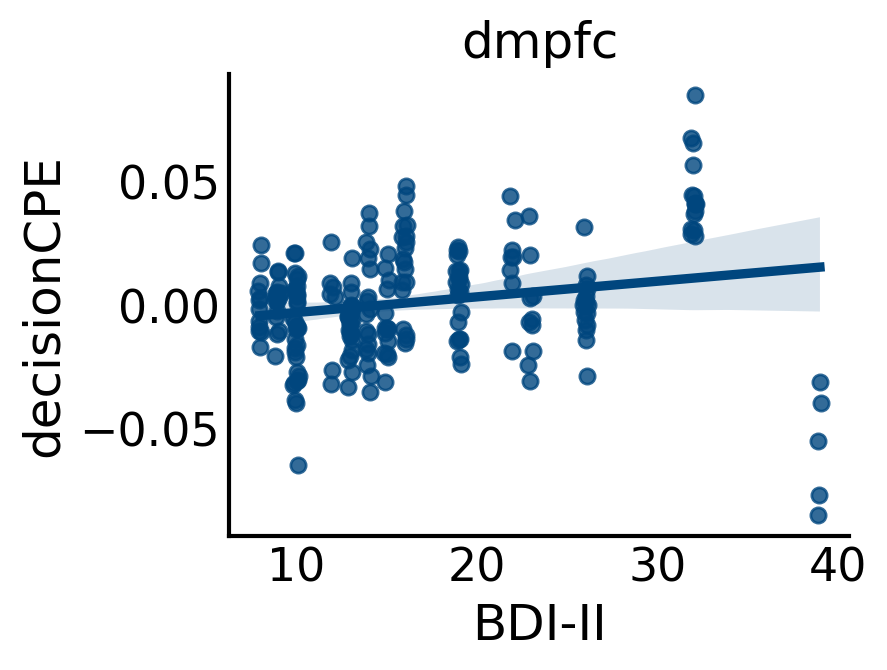

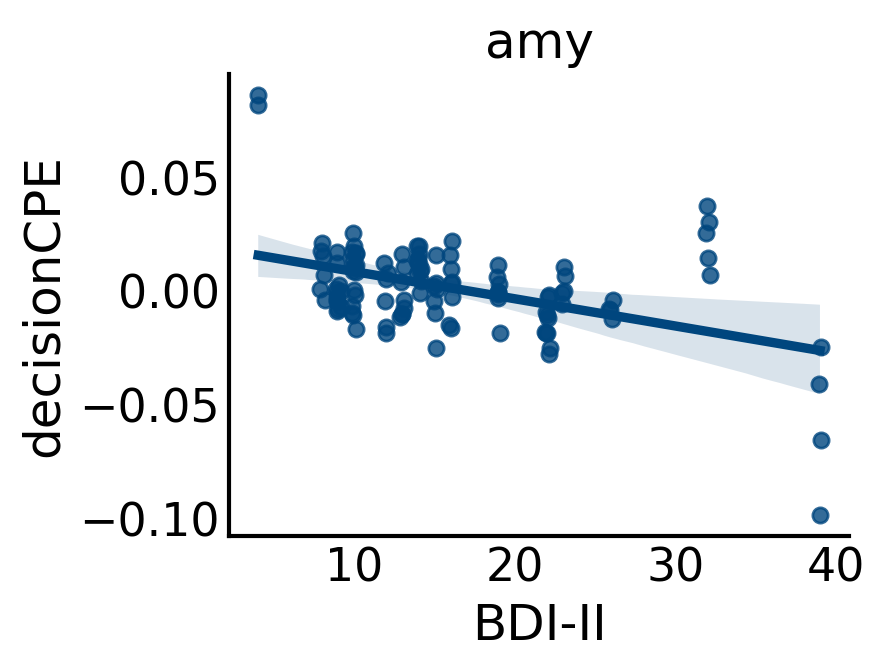

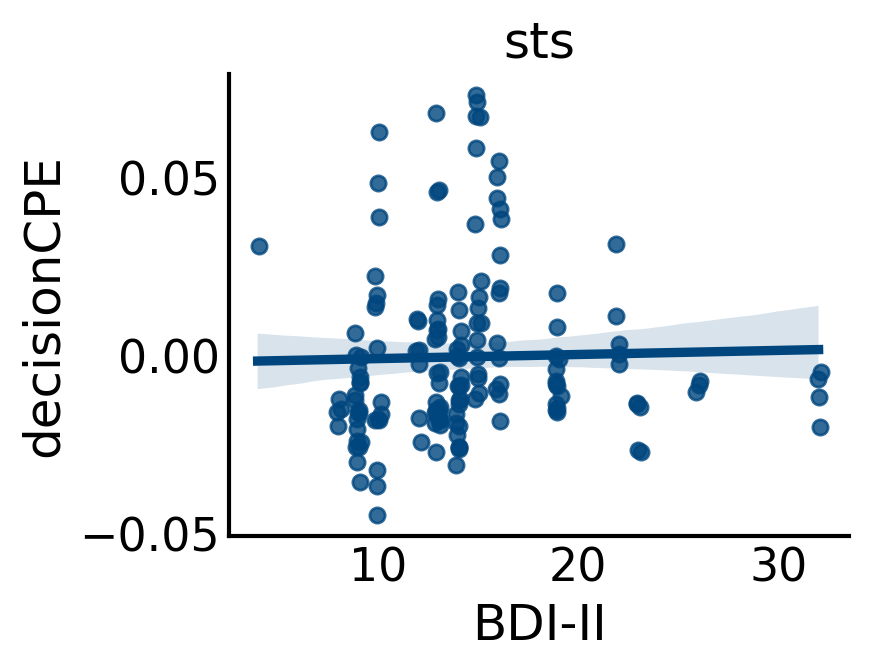

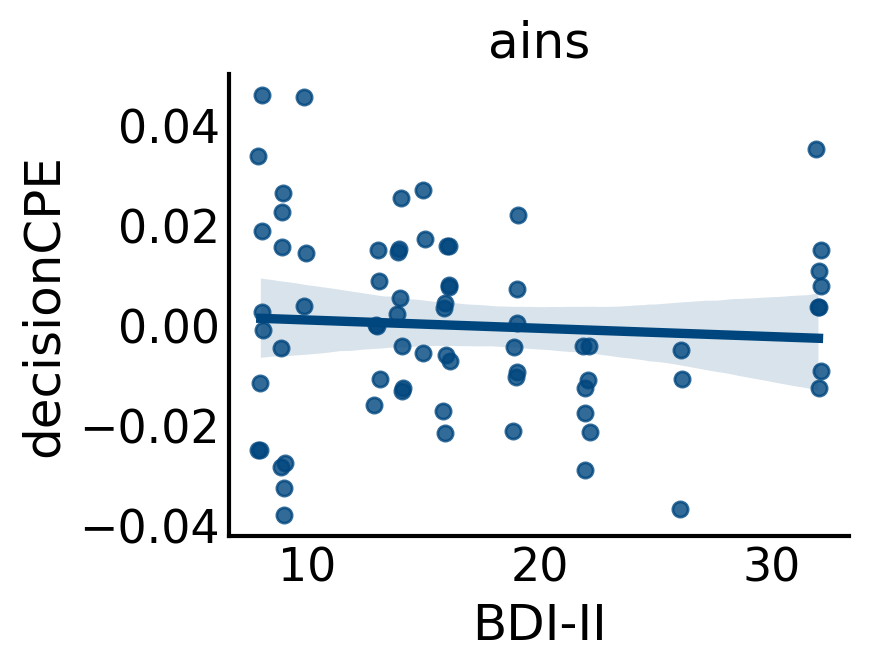

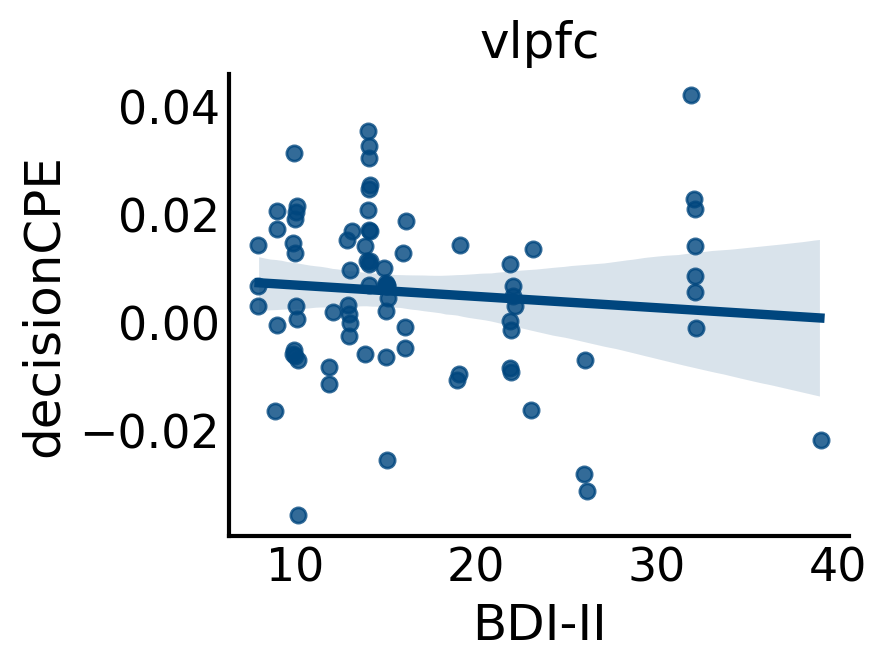

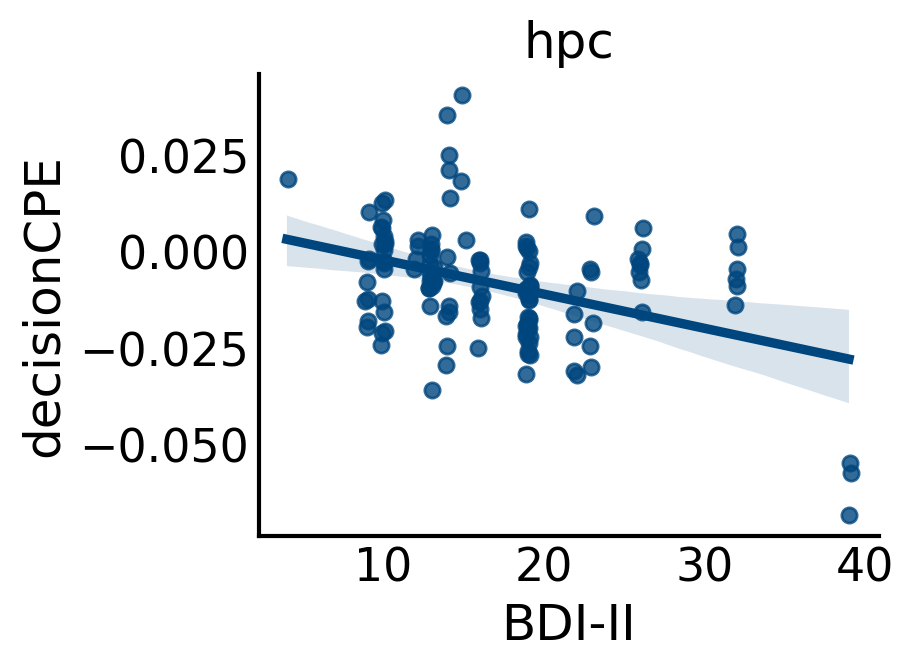

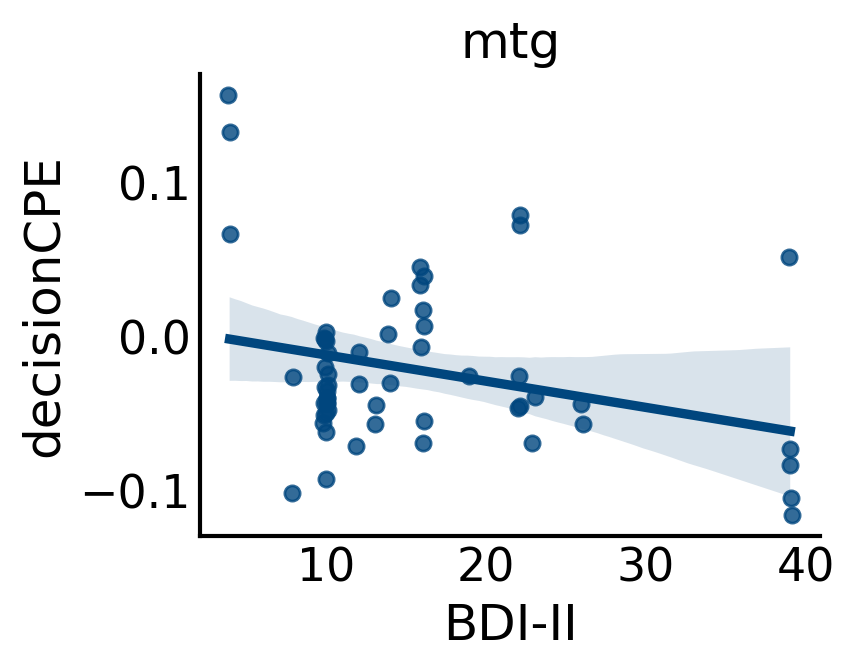

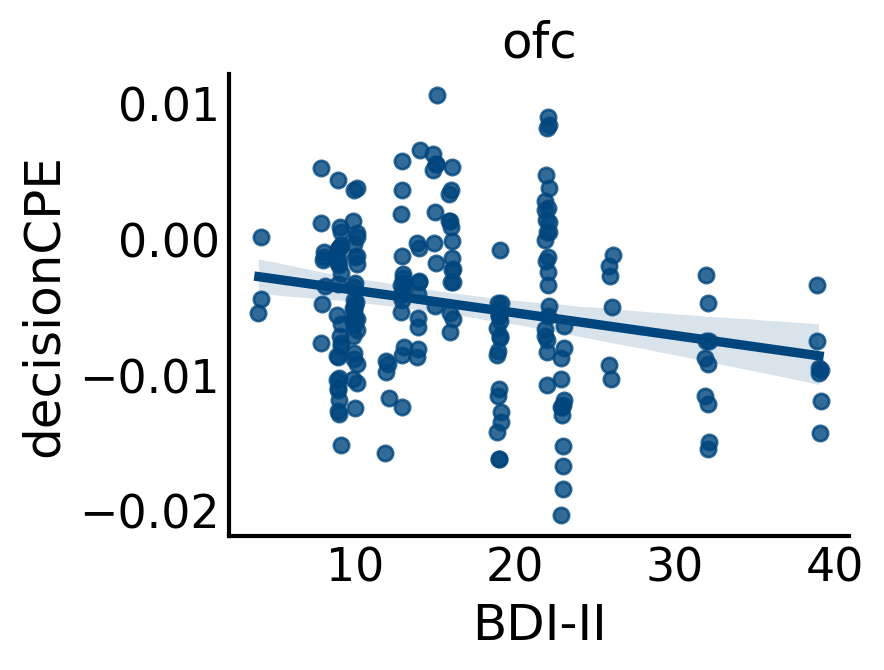

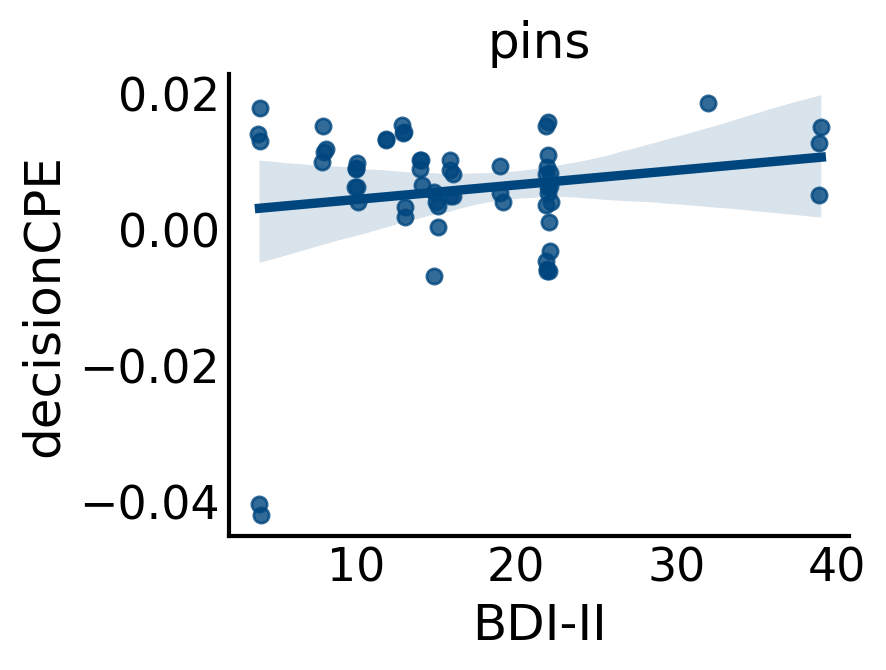

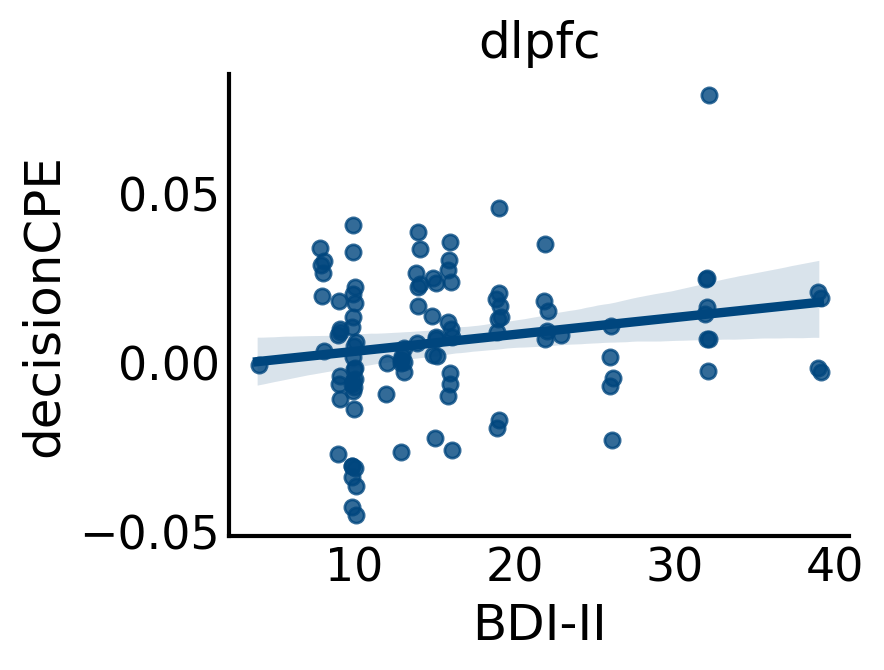

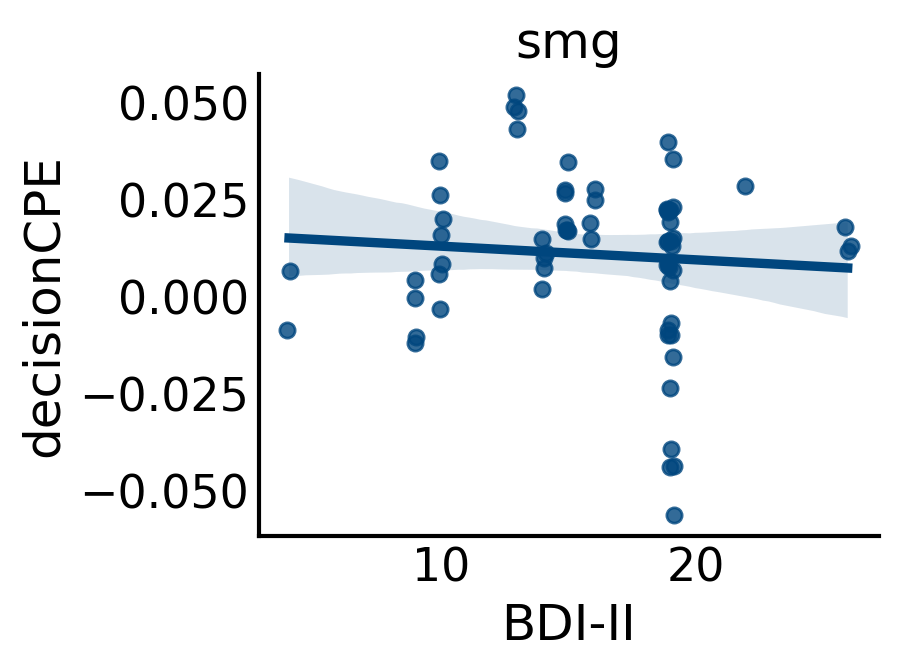

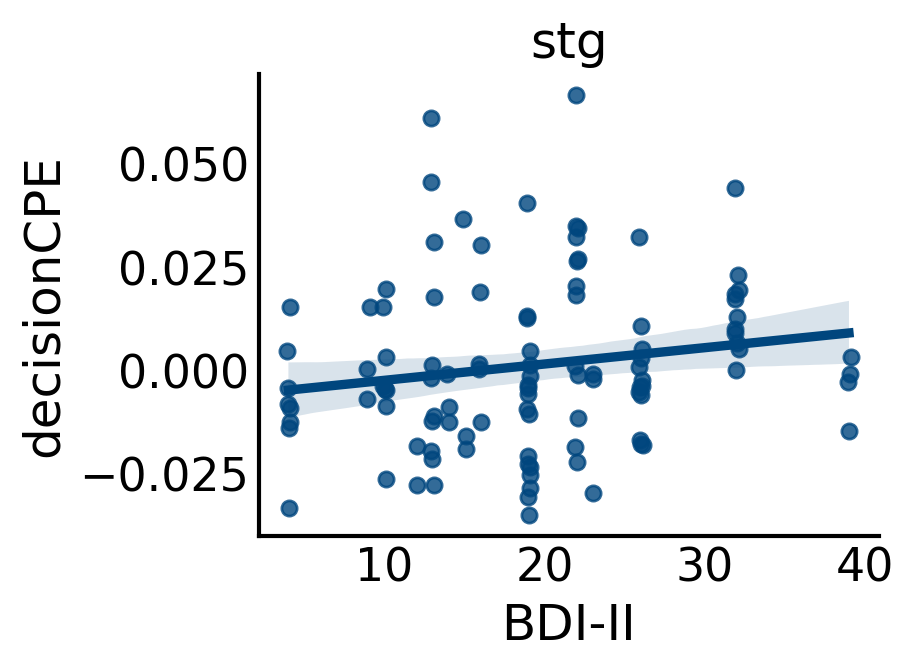

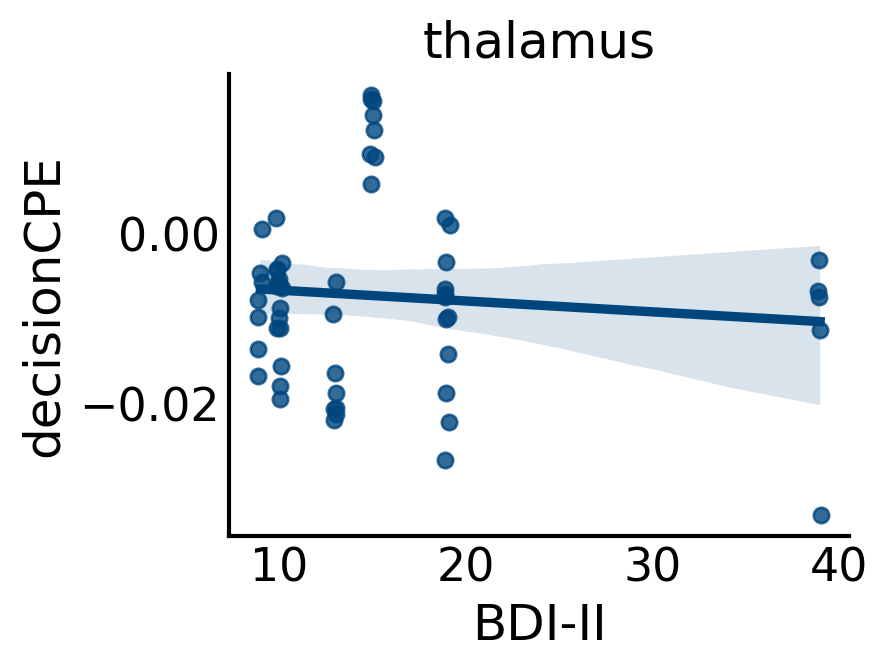

In [41]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    

# RT ~ CPE:Pow Regressions

In [42]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

In [43]:
rt_vars   = ['decisionCPE','band_pow','decisionCPE:band_pow']
rt_fit = fit_mixed_model(reg_df,rt_vars,outcome_var,rand_eff_var,reml=False)
print(rt_fit.summary())
rt_fit.bic    

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         logRT_t1   
No. Observations:          222592          Method:                     ML         
No. Groups:                1620            Scale:                      0.1330     
Min. group size:           65              Log-Likelihood:             -94904.5031
Max. group size:           148             Converged:                  Yes        
Mean group size:           137.4                                                  
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               1.030    0.006 172.364 0.000  1.018  1.042
decisionCPE                             0.038    0.002  21.481 0.000  0.034  0.041
band_pow                   

189993.7025419285


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [44]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
rt_vars   = ['decisionCPE','band_pow','decisionCPE:band_pow']


In [45]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        rt_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [46]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}RT_{band}_roi_results.csv')

In [47]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_decisionCPE,raw_band_pow,raw_decisionCPE:band_pow,Intercept,decisionCPE,band_pow,decisionCPE:band_pow,band
0,DA023_lac1-lac2,DA023,acc,14,-0.119069,-0.007417,0.039787,0.054203,0.900816,0.024333,0.018991,0.054019,alpha
1,DA023_lac2-lac3,DA023,acc,14,-0.118544,0.010614,-0.005125,0.025893,0.901340,0.042364,-0.025922,0.025709,alpha
2,DA023_lac3-lac4,DA023,acc,14,-0.118824,0.010683,-0.010114,-0.029642,0.901061,0.042433,-0.030910,-0.029826,alpha
3,MS002_lacas1-lacas2,MS002,acc,14,-0.286953,-0.002839,0.047792,0.012905,0.732931,0.028912,0.026996,0.012721,alpha
4,MS002_lacas2-lacas3,MS002,acc,14,-0.286226,0.005943,0.024299,-0.021243,0.733659,0.037693,0.003503,-0.021428,alpha
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.271276,0.032937,-0.069939,-0.025379,1.273345,0.087535,-0.047249,-0.053674,alpha
1616,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.270488,0.037056,0.069365,-0.110725,1.272558,0.091654,0.092056,-0.139020,alpha
1617,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.270104,0.032639,0.104121,-0.019058,1.272174,0.087236,0.126812,-0.047353,alpha
1618,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.270835,0.038043,0.090700,-0.068268,1.272904,0.092641,0.113391,-0.096563,alpha


In [48]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results['decisionCPE:band_pow'][roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=-0.05263732432045536, pvalue=0.958075602881157, df=192),
 'dmpfc': TtestResult(statistic=8.246717725534639, pvalue=1.612260454017851e-14, df=215),
 'amy': TtestResult(statistic=5.465986417374659, pvalue=2.8216678086011993e-07, df=112),
 'sts': TtestResult(statistic=10.16019283249182, pvalue=7.015637052931033e-19, df=154),
 'ains': TtestResult(statistic=3.436843793459129, pvalue=0.0009942476032391992, df=70),
 'vlpfc': TtestResult(statistic=1.2670071182161786, pvalue=0.20878362725553296, df=81),
 'hpc': TtestResult(statistic=-3.5949929103669964, pvalue=0.0004547785857969842, df=134),
 'mtg': TtestResult(statistic=1.4712701101178398, pvalue=0.14681548563139227, df=56),
 'ofc': TtestResult(statistic=-4.7571753459070205, pvalue=3.7430519075013935e-06, df=201),
 'pins': TtestResult(statistic=-0.7379238308632317, pvalue=0.4634857424174441, df=59),
 'dlpfc': TtestResult(statistic=3.9383269223054644, pvalue=0.00014716671860506915, df=106),
 'smg': TtestResult(stat

In [49]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_decisionCPE,raw_band_pow,raw_decisionCPE:band_pow,Intercept,decisionCPE,band_pow,decisionCPE:band_pow,band
0,DA023_lac1-lac2,DA023,acc,14,-0.119069,-0.007417,0.039787,0.054203,0.900816,0.024333,0.018991,0.054019,alpha
1,DA023_lac2-lac3,DA023,acc,14,-0.118544,0.010614,-0.005125,0.025893,0.901340,0.042364,-0.025922,0.025709,alpha
2,DA023_lac3-lac4,DA023,acc,14,-0.118824,0.010683,-0.010114,-0.029642,0.901061,0.042433,-0.030910,-0.029826,alpha
3,MS002_lacas1-lacas2,MS002,acc,14,-0.286953,-0.002839,0.047792,0.012905,0.732931,0.028912,0.026996,0.012721,alpha
4,MS002_lacas2-lacas3,MS002,acc,14,-0.286226,0.005943,0.024299,-0.021243,0.733659,0.037693,0.003503,-0.021428,alpha
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.271276,0.032937,-0.069939,-0.025379,1.273345,0.087535,-0.047249,-0.053674,alpha
1616,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.270488,0.037056,0.069365,-0.110725,1.272558,0.091654,0.092056,-0.139020,alpha
1617,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.270104,0.032639,0.104121,-0.019058,1.272174,0.087236,0.126812,-0.047353,alpha
1618,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.270835,0.038043,0.090700,-0.068268,1.272904,0.092641,0.113391,-0.096563,alpha


In [50]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [51]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [52]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [53]:
fe_results['roi_cpepow_pval'] = [roi_fit_dict[roi].pvalues['decisionCPE:band_pow'] for roi in fe_results.roi.tolist()]


In [54]:
fe_results

,Intercept,decisionCPE,band_pow,decisionCPE:band_pow,roi,roi_cpepow_pval
0,1.019884,0.031750,-0.020796,-0.000184,acc,0.992619
1,0.992833,0.049094,-0.039657,0.037751,dmpfc,0.022550
2,1.039502,0.041753,-0.042308,0.030419,amy,0.185723
3,1.044409,0.023961,-0.028295,0.022628,sts,0.074058
4,0.998830,0.048611,-0.009222,0.034885,ains,0.314327
5,1.017619,0.032876,-0.035994,0.008378,vlpfc,0.739229
6,0.996174,0.033965,-0.036776,-0.018721,hpc,0.425751
7,1.086597,0.048457,-0.009510,0.007841,mtg,0.756481
8,1.038994,0.036685,-0.022249,-0.017445,ofc,0.277745
9,1.099642,0.025807,-0.020960,-0.009602,pins,0.754378


In [55]:
bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha

0.0035714285714285718

In [56]:
sig_rois = fe_results.roi[fe_results.roi_cpepow_pval <= bonferr_alpha].tolist()
sig_rois

[]

In [57]:
# plot_roi_model_results(roi_fit_results,'roi','decisionCPE:band_pow')


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


In [58]:
# # plot ROI beta distribution
# sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# plt.title(f'ACC n={n}')

# sns.despine()

In [59]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data['decisionCPE:band_pow'])
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr 0.30058303754801796 2.1631895295963102e-05
dmpfc pearsonr 0.4151622534371085 2.079164652704242e-10
amy pearsonr -0.006782969488564164 0.9431565525305499
sts pearsonr 0.18018923593586847 0.024859717584302148
ains pearsonr 0.5717011258553198 1.9142154974307157e-07
vlpfc pearsonr 0.4192890109814212 8.824625129110187e-05
hpc pearsonr 0.24151391601606176 0.004773363144133632
mtg pearsonr 0.20536835153882801 0.12539095129602315
ofc pearsonr 0.36864090030316693 6.731831379551223e-08
pins pearsonr -0.012674464416539665 0.9234295818773615
dlpfc pearsonr 0.25518116539031027 0.007985564304121716
smg pearsonr -0.42130061433676363 0.000427073138179709
stg pearsonr -0.3001805662821107 0.0018633139787043594
thalamus pearsonr 0.14397924930979683 0.2809115989412216


In [60]:
sig_rho

[('acc', 0.30058303754801796, 2.1631895295963102e-05),
 ('dmpfc', 0.4151622534371085, 2.079164652704242e-10),
 ('sts', 0.18018923593586847, 0.024859717584302148),
 ('ains', 0.5717011258553198, 1.9142154974307157e-07),
 ('vlpfc', 0.4192890109814212, 8.824625129110187e-05),
 ('hpc', 0.24151391601606176, 0.004773363144133632),
 ('ofc', 0.36864090030316693, 6.731831379551223e-08),
 ('dlpfc', 0.25518116539031027, 0.007985564304121716),
 ('smg', -0.42130061433676363, 0.000427073138179709),
 ('stg', -0.3001805662821107, 0.0018633139787043594)]

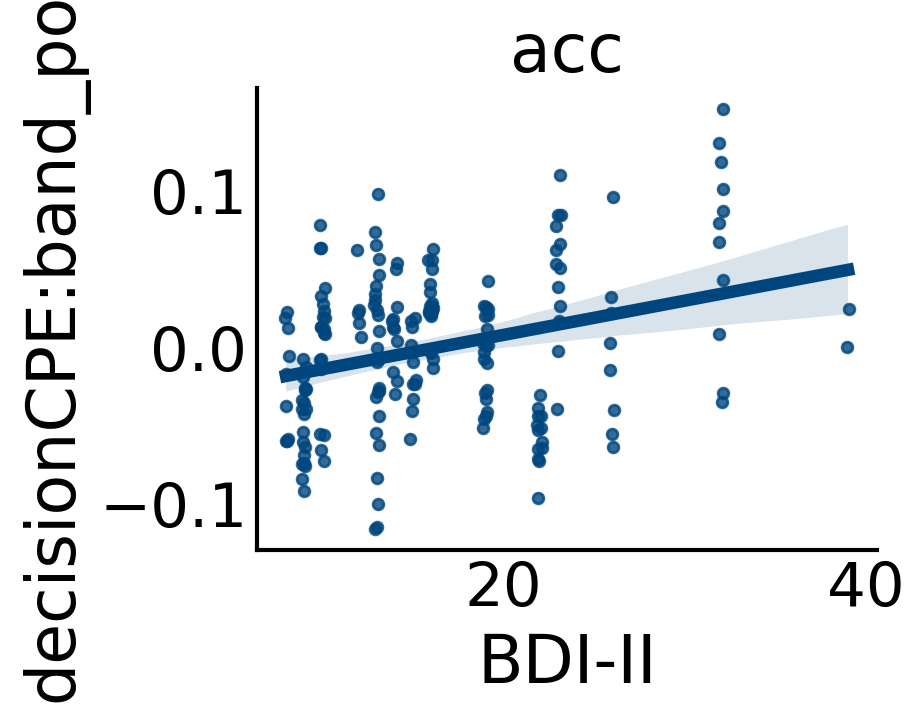

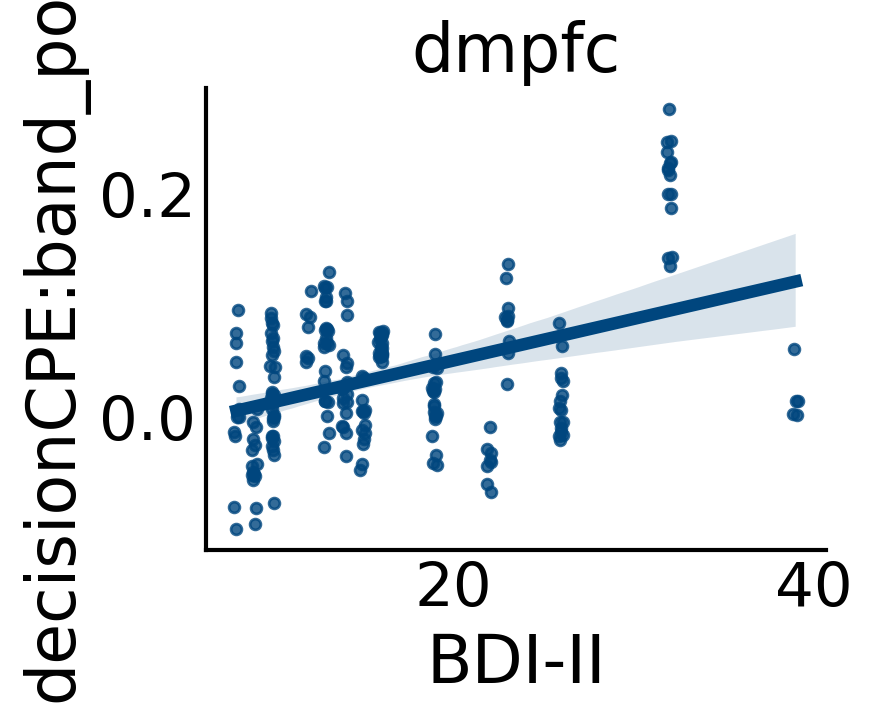

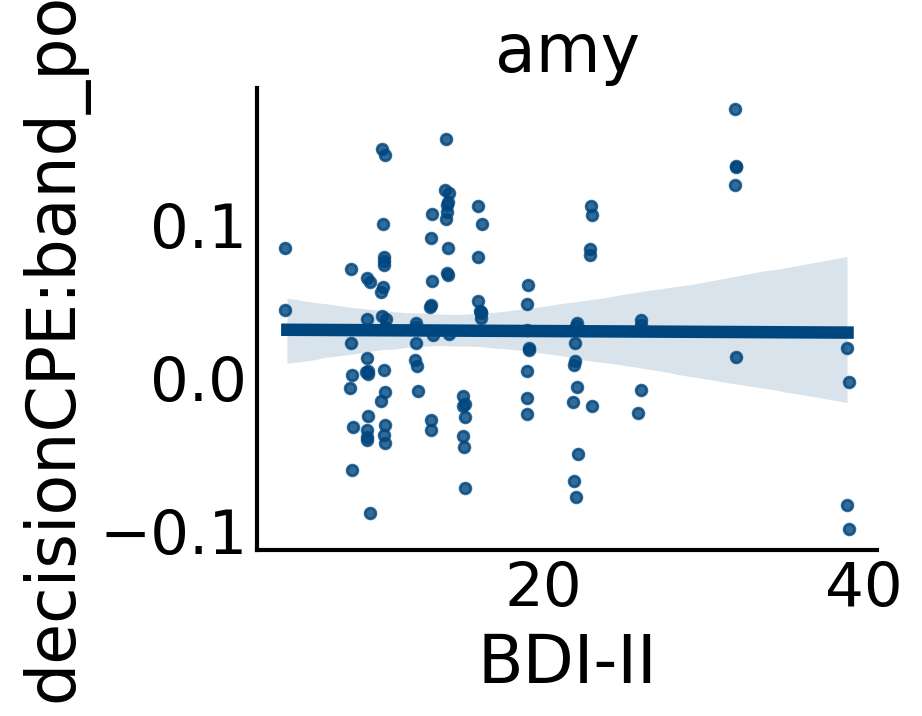

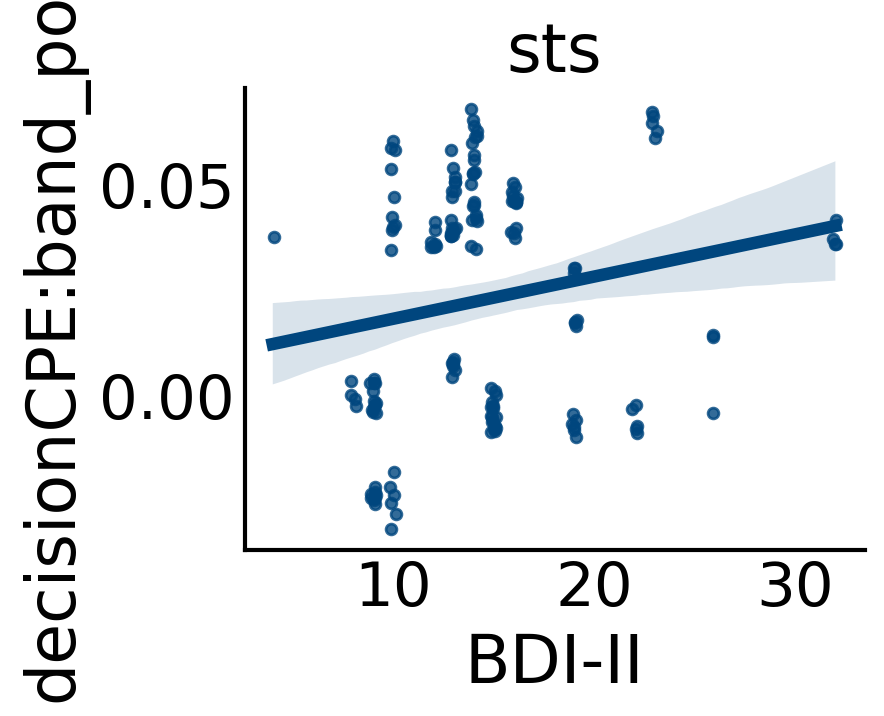

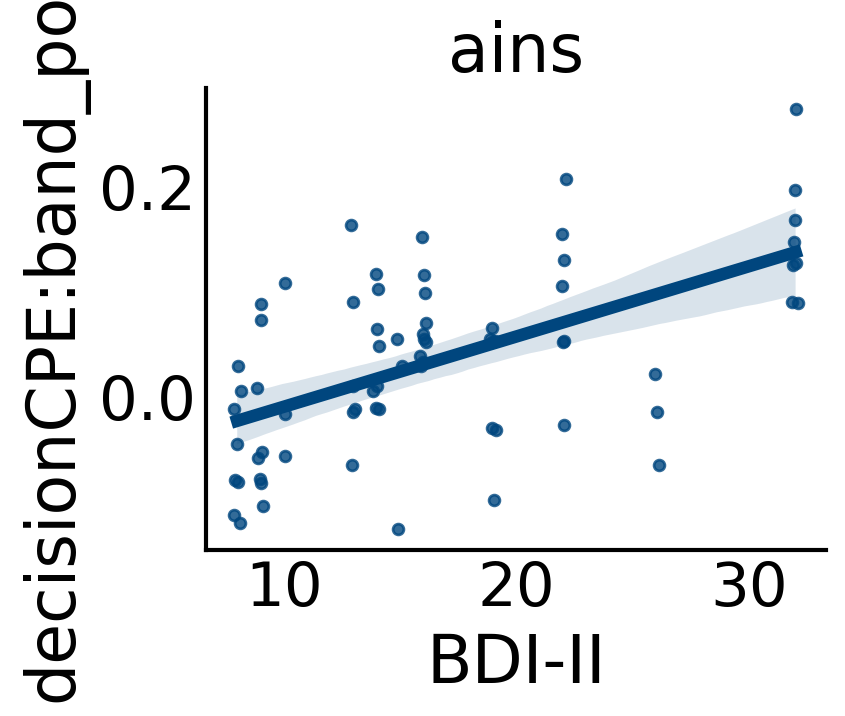

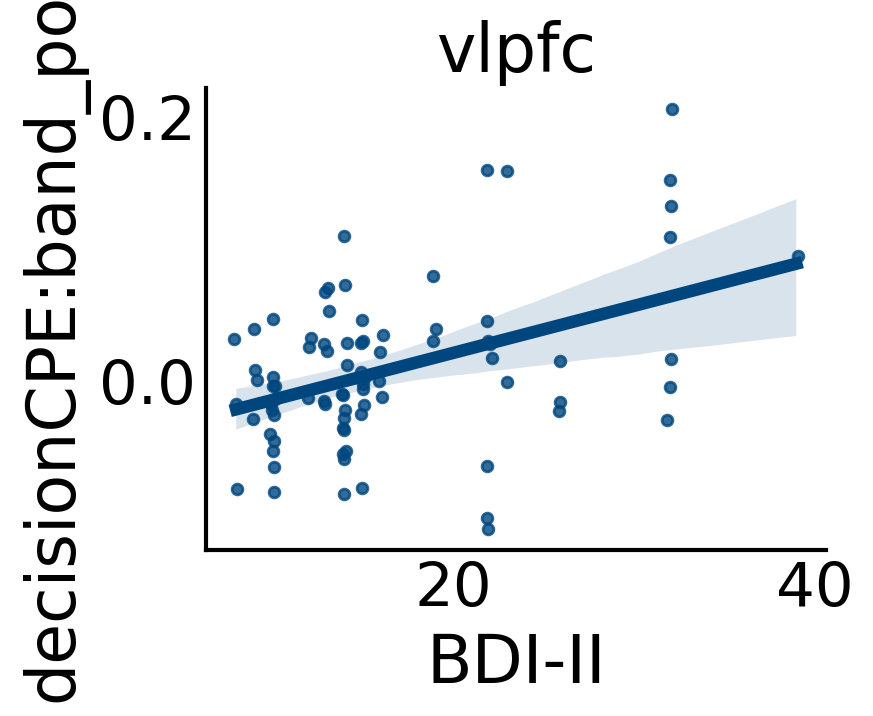

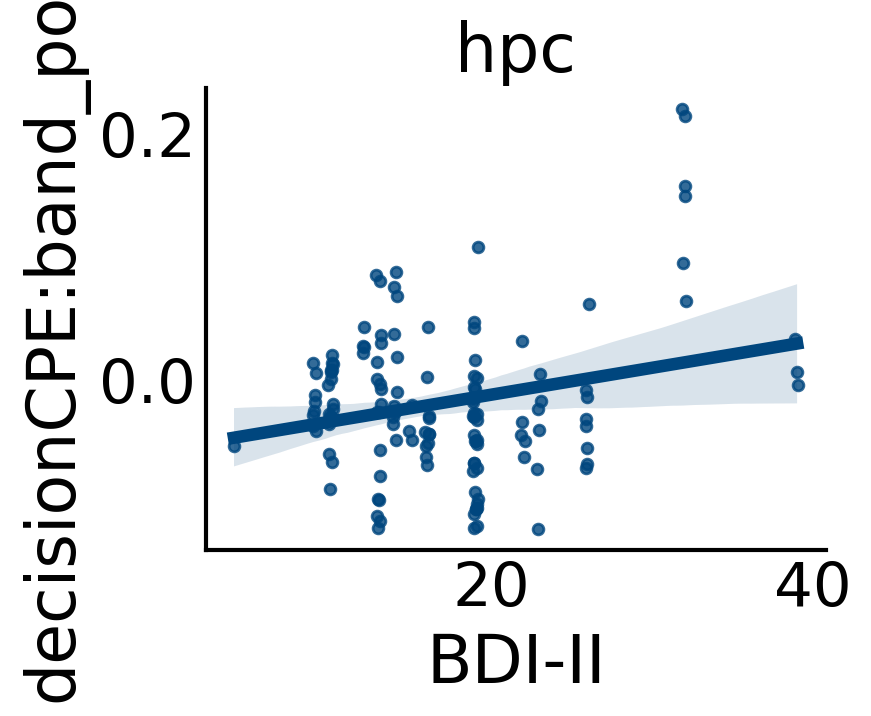

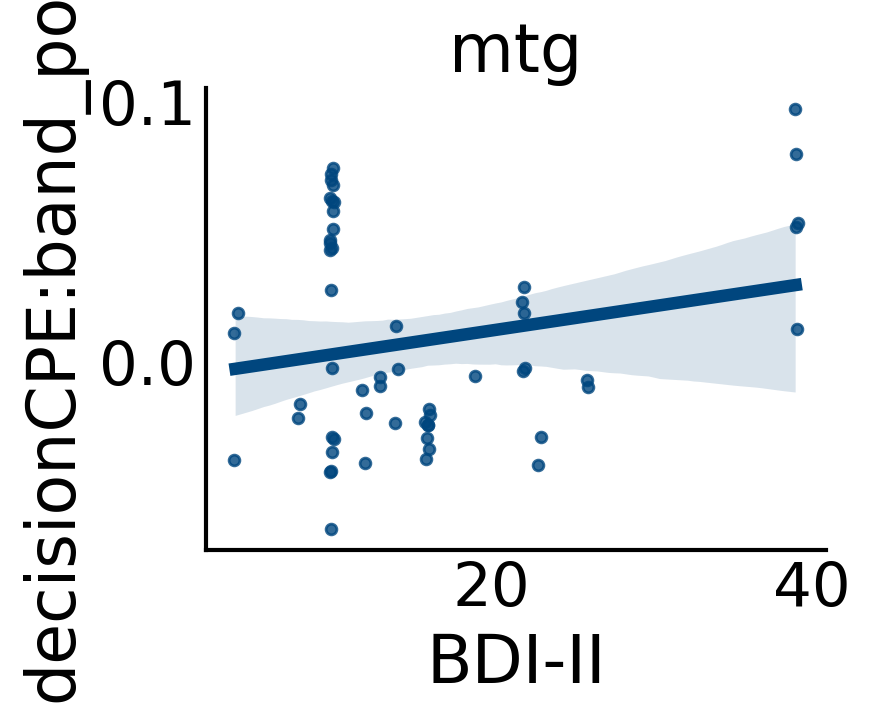

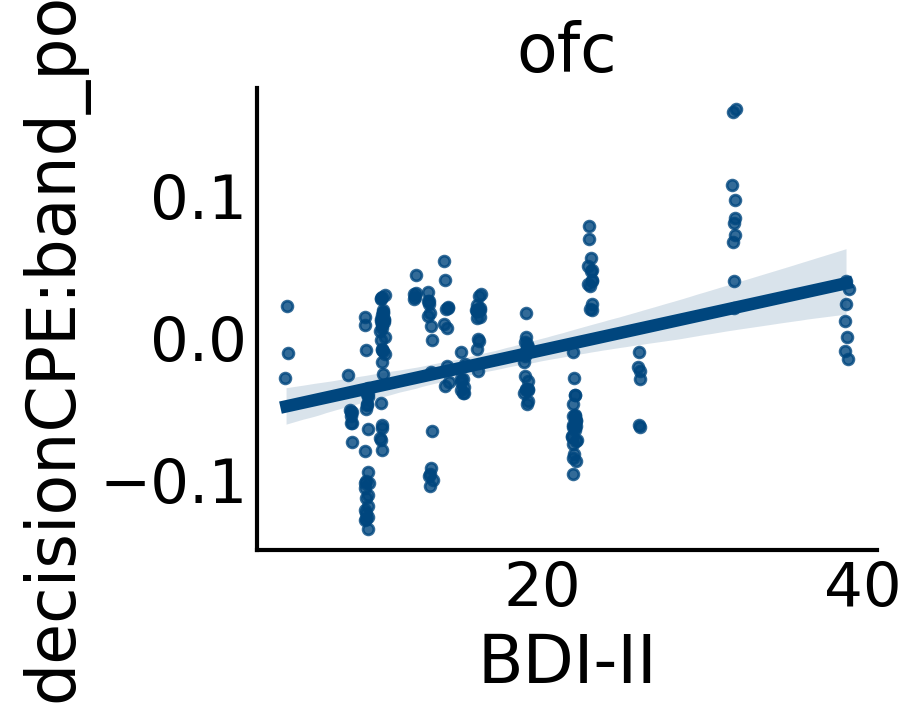

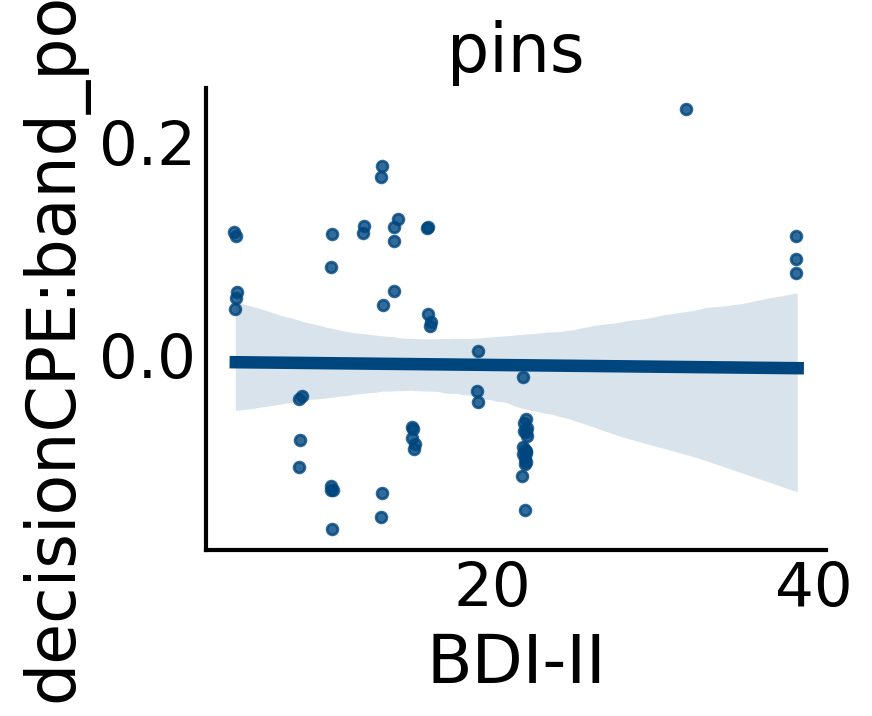

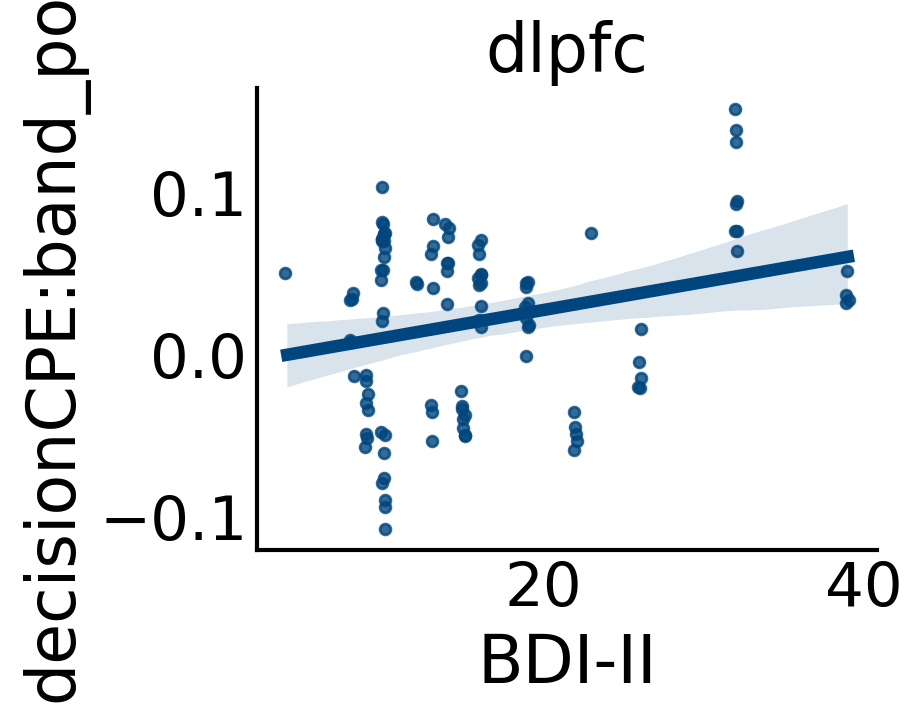

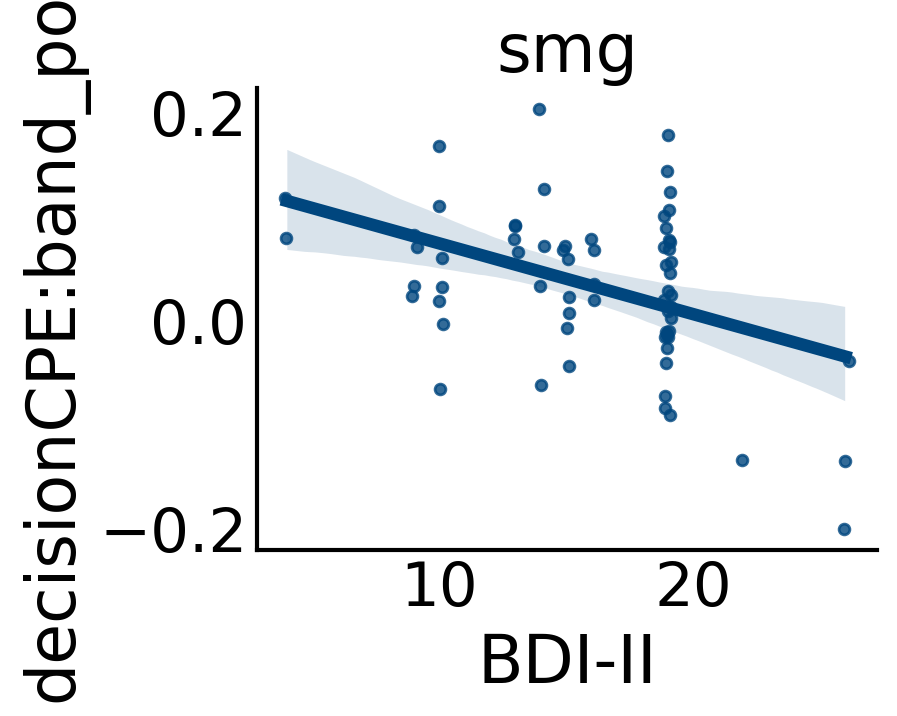

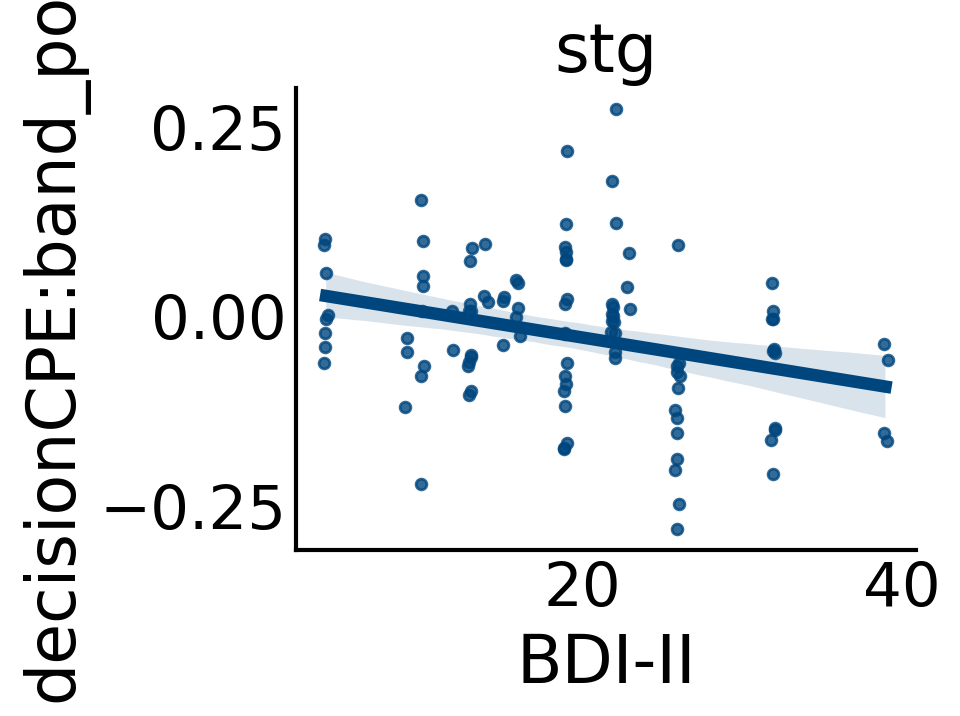

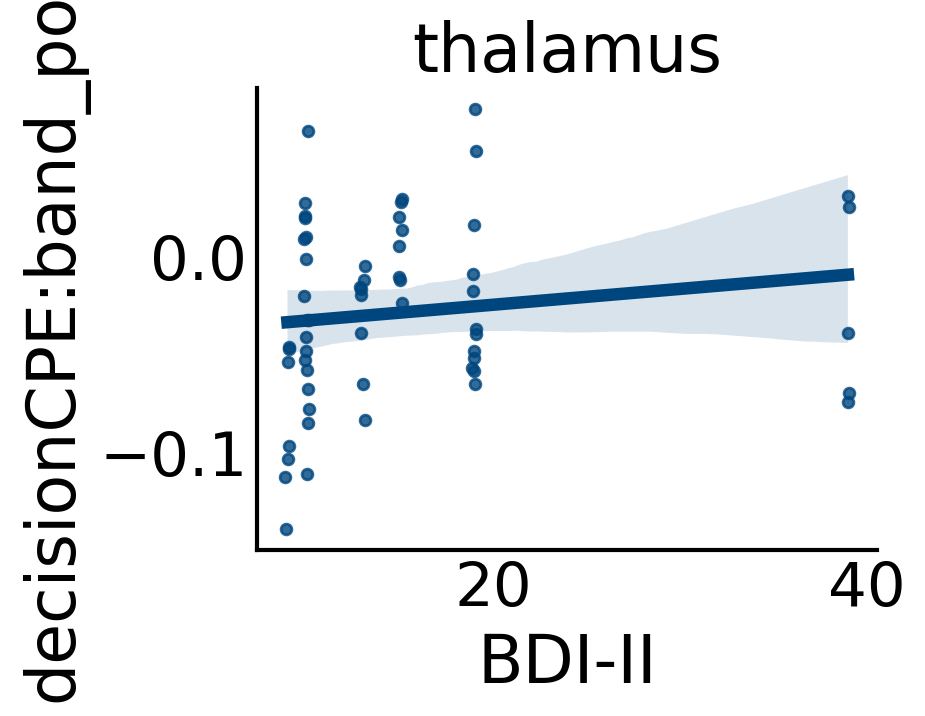

In [61]:

sns.set_context("poster",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE:band_pow',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':15}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    